# Fine-Tuning Techniques for Customer Support Summarization

## Introduction

Fine-tuning a pretrained large language model (LLM) is a practical way to turn a general model into a specialist. In this notebook we adapt a seq2seq model so it can summarize customer-support style chats (similar to finance-service escalations) with accuracy and clarity. The workflow mirrors any domain adaptation effort: understand the task, collect representative data, clean and tokenize it, fine-tune the model, then evaluate and iterate.

By the end of this reading you will be able to:

- Define task-specific requirements for fine-tuning an LLM on chat-style summaries.
- Collect (or download) and preprocess a dialogue dataset so it matches the model inputs.
- Fine-tune a pretrained summarization model on the SAMSum corpus (a stand-in for customer-service transcripts).
- Evaluate and optimize the fine-tuned model with ROUGE so you know when it is ready for production.

## Step-by-Step Guide to Fine-Tuning an LLM

We follow six core steps. Additional sub-sections expand on the "how" for each step, but keep these main stages in mind:

1. **Step 1 – Understand the Task:** Clarify the objective, labels, and domain (customer-support chat summaries).
2. **Step 2 – Collect the Dataset:** Acquire dialogue data that mirrors production traffic (SAMSum or your internal chats).
3. **Step 3 – Preprocess the Data:** Clean, tokenize, verify sequence lengths, and create any helper splits.
4. **Step 4 – Fine-Tune the Pretrained Model:** Load FLAN-T5, configure training arguments, and run Seq2Seq training.
5. **Step 5 – Evaluate the Fine-Tuned Model:** Use ROUGE (or accuracy/precision/recall for classification) on the validation/test sets.
6. **Step 6 – Optimize the Model:** Tune hyperparameters or apply augmentation techniques to push performance further.

## Step 1: Understand the Task

- **Task definition:** Abstractive summarization of informal customer-support style chats. The model outputs a concise synopsis that triage teams can read quickly.
- **Domain context:** Conversations include multiple speakers, shorthand, emojis, and domain terms (e.g., finance accounts, refunds, shipping). We preserve speaker tags because they provide structure.
- **Success criteria:** High ROUGE scores plus qualitative readability (support leads can trust the summaries).
- **Why this matters:** Without a crisp task definition, it is impossible to pick the right data, prompts, or evaluation metric.

> ## Step 2: Collect the Dataset
 >
> - **Primary source:** [SAMSum](https://huggingface.co/datasets/samsum) – 16k messenger-like chats with human-written summaries.
 > - **Why SAMSum?** It mirrors the tone, pace, and multi-speaker structure of real customer-service escalations, so it is a strong public proxy for finance/contact-center data.
 > - **Enterprise alternative:** Replace SAMSum with anonymized internal chat logs labeled with the summaries or categories you care about.
 > - **Learner action:** If `load_dataset("samsum")` is blocked, download `train.json`, `validation.json`, and `test.json` from the "Files" tab and point the code to your local directory.

## Step 3: Preprocess the Data

Preprocessing ensures the raw dialogues match what the model expects.

1. **Load & Inspect:** Use the `datasets` library to pull SAMSum (or your local JSON files). Immediately inspect a record so stakeholders can confirm the format.
2. **Tokenize:** Convert dialogues and summaries into `input_ids`, `attention_mask`, and `labels` using the FLAN-T5 tokenizer. We prepend "summarize:" so the model knows the intent.
3. **Verify Splits:** SAMSum already includes train/validation/test partitions. The next code cell prints their sizes and a sample dialogue to confirm the metadata.
4. **Check Sequence Lengths:** Plot histograms to ensure your `max_length` choices (512 for dialogues, 128 for summaries) avoid excessive truncation.
5. **Optional Augmentation:** Techniques such as synonym replacement (NLTK WordNet example below) or back-translation add mild variation when data is scarce.

These sub-steps feed the fine-tuning pipeline with clean, well-structured tensors instead of raw text blobs.

In [1]:
# Install/upgrade the core libraries used throughout the notebook
%pip install --upgrade datasets py7zr evaluate rouge_score

from pathlib import Path

from datasets import load_dataset
from transformers import AutoTokenizer

# --- Step 1: Load the SAMSum dataset ---
dataset_id = "knkarthick/samsum"  # mirror of SAMSum that often stays available
print(f"Loading dataset: {dataset_id}")
print("Tip: if you see an auth error, run `huggingface-cli login` in a terminal once.")

try:
    dataset = load_dataset(dataset_id)
except Exception as err:
    print(f"Remote download failed: {err}")
    print("Falling back to local JSON files. Download train/validation/test from the dataset page if needed.")
    local_data_dir = Path("c:/data/samsum")
    dataset = load_dataset(
        "json",
        data_files={
            "train": str(local_data_dir / "train.json"),
            "validation": str(local_data_dir / "validation.json"),
            "test": str(local_data_dir / "test.json"),
        },
    )
    print(f"Loaded SAMSum from local folder: {local_data_dir}")

print(f"Training samples: {len(dataset['train'])}")
print(f"Sample Dialogue:\n{dataset['train'][0]['dialogue']}")
print(f"Sample Summary:\n{dataset['train'][0]['summary']}")

# --- Step 2: Initialize the tokenizer ---
model_checkpoint = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# --- Step 3: Tokenize dialogues and summaries ---
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["dialogue"]]  # keep speaker turns intact
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)
print("\nData tokenized successfully.")

Note: you may need to restart the kernel to use updated packages.


c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset: knkarthick/samsum
Tip: if you see an auth error, run `huggingface-cli login` in a terminal once.
Training samples: 14731
Sample Dialogue:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Sample Summary:
Amanda baked cookies and will bring Jerry some tomorrow.


Map: 100%|██████████| 818/818 [00:00<00:00, 6144.29 examples/s]


Data tokenized successfully.


### 3.1 Verify the Built-in Splits

SAMSum already includes three partitions, so there is no need to reshuffle:

- **Train:** Used to update model weights.
- **Validation:** Used for metric tracking during training (early stopping, hyperparameter tweaks).
- **Test:** Held out until the very end for unbiased reporting.

The code right after this cell prints the record counts and shows a sample dialogue/summary pair so you can double-check the data quality.

In [2]:
# Inspect the ready-made splits to build intuition
split_lengths = {split: len(dataset[split]) for split in dataset.keys()}
for split_name, length in split_lengths.items():
    print(f"{split_name.title():<11}: {length:>5} conversations")

example = dataset["train"][0]
print("\nSample dialogue:")
print(example["dialogue"])
print("\nReference summary:")
print(example["summary"])

Train      : 14731 conversations
Validation :   818 conversations
Test       :   819 conversations

Sample dialogue:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

Reference summary:
Amanda baked cookies and will bring Jerry some tomorrow.


### 3.2 Analyze Sequence Lengths

Summarization succeeds only if the model sees complete dialogues and concise targets.

- **Why check lengths?** Dialogues longer than `max_length=512` get truncated; summaries longer than 128 tokens slow training.
- **What to look for?** Long tails in the histogram that might justify higher cutoffs or chunking.
- **Action:** Use the matplotlib chart in the next cell to confirm most customer chats fit inside the window. Adjust `max_length` if needed before training.

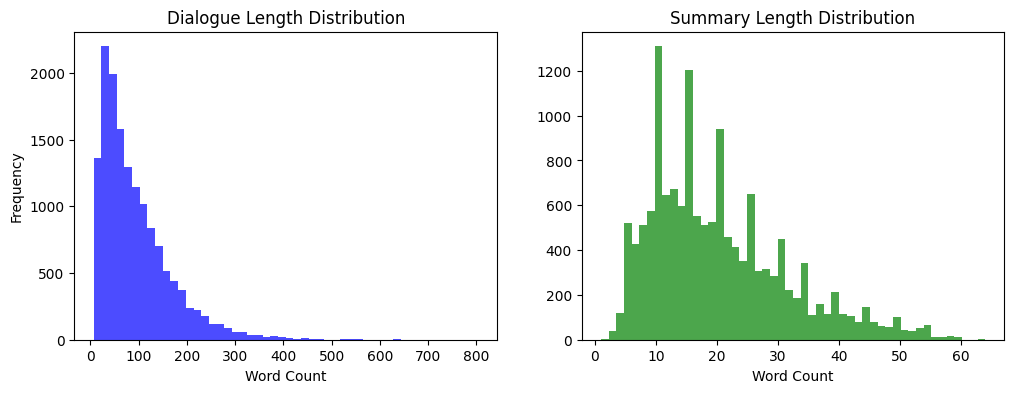

Max Dialogue Length: 803
Max Summary Length: 64


In [3]:
import matplotlib.pyplot as plt

# Calculate lengths of dialogues in the training set
dialogue_lengths = [len(x.split()) for x in dataset['train']['dialogue']]
summary_lengths = [len(x.split()) for x in dataset['train']['summary']]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(dialogue_lengths, bins=50, color='blue', alpha=0.7)
axes[0].set_title('Dialogue Length Distribution')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

axes[1].hist(summary_lengths, bins=50, color='green', alpha=0.7)
axes[1].set_title('Summary Length Distribution')
axes[1].set_xlabel('Word Count')

plt.show()

print(f"Max Dialogue Length: {max(dialogue_lengths)}")
print(f"Max Summary Length: {max(summary_lengths)}")

### 3.3 Optional Data Augmentation

When the dataset is small, light-touch augmentation keeps the model from overfitting to exact phrasing.

- **Purpose:** Give the model paraphrased wording while preserving intent.
- **Options:** Synonym replacement (shown below with NLTK WordNet), back-translation, or prompt-based paraphrases from another LLM.
- **Best practice:** Keep changes subtle so the summary label is still correct.

The accompanying code picks random tokens and swaps them with WordNet synonyms—perfect for quick experiments.

In [4]:
import random
import nltk
from nltk.corpus import wordnet

# Download once per environment (quiet=True keeps the logs clean)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word)
    return list(synonyms)

def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    candidate_words = [word for word in words if word.isalnum()]
    random.shuffle(candidate_words)

    replacements = 0
    for word in candidate_words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if w == word else w for w in new_words]
            replacements += 1
        if replacements >= n:
            break

    return ' '.join(new_words)

original_text = "The customer service was excellent and very helpful."
augmented_text = synonym_replacement(original_text, n=2)

print(f"Original : {original_text}")
print(f"Augmented: {augmented_text}")

Original : The customer service was excellent and very helpful.
Augmented: The customer service was first-class and identical helpful.


## Step 4: Fine-Tune the Pretrained Model

Now that the data is tokenized, connect it to a generation-capable backbone.

- **Model choice:** `google/flan-t5-small` keeps training fast while supporting instruction-style prompts like "summarize:".
- **Why Seq2Seq?** Summarization requires the model to generate free-form text, not pick a class label.
- **Core ingredients:**
  1. `AutoModelForSeq2SeqLM` for the architecture.
  2. `Seq2SeqTrainingArguments` to define epochs, learning rate, batch size, and evaluation cadence.
  3. `DataCollatorForSeq2Seq` to dynamically pad batches (saves memory).
- **Learner action:** Review the next code cell and adjust hyperparameters (epochs, batch size, fp16) to match your hardware.

In [5]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# 1. Load Model
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# 2. Define Arguments
args = Seq2SeqTrainingArguments(
    output_dir="samsum-model",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Smaller batch size for generation tasks
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,    # Essential for calculating ROUGE during training
    fp16=False,                    # Set to True if using GPU
)

# 3. Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 4. Initialize Trainer (Conceptual - requires compute_metrics defined below)
# trainer = Seq2SeqTrainer(
#     model=model,
#     args=args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
# )

c:\Users\amansahni\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\amansahni\.cache\huggingface\hub\models--google--flan-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fall

## Step 5: Evaluate the Fine-Tuned Model

Evaluation tells you whether the model generalizes beyond the training chats.

- **Primary metric:** ROUGE (1, 2, L) measures token overlap between generated and reference summaries. Higher is better.
- **Why not accuracy?** Summaries are free-form text; overlap-based metrics capture fluency better than exact matches.
- **Process:**
  1. Generate summaries on the validation/test split (`predict_with_generate=True`).
  2. Decode predictions and references back into text.
  3. Compute ROUGE via the `evaluate` library and monitor length statistics (`gen_len`).
- **Learner action:** Run the next code cell after training to quantify improvements; compare against baselines such as "copy the first sentence."

In [ ]:
import evaluate
import numpy as np

rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Decode generated summaries
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Compute ROUGE
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

# Now you would pass this to the Seq2SeqTrainer:
# trainer = Seq2SeqTrainer(..., compute_metrics=compute_metrics)

## Step 6: Optimize the Fine-Tuned Model

Once you get a baseline ROUGE score, keep improving the model with **small, controlled experiments**. Optimization is just a structured way of answering two questions:

1. *Can I tweak the training recipe?* (learning rate, batch size, epochs, label smoothing, etc.)
2. *Can I give the model slightly better data?* (augment rare patterns, add more chats, balance categories).

### Easy Optimization Checklist

- **Learning rate sweeps:** Try `1e-4`, `5e-5`, `2e-5` and see which keeps validation ROUGE highest.
- **Epoch budgeting:** Short chats often converge in 2–4 epochs; monitor when validation ROUGE stops rising.
- **Batch size vs. memory:** Increase batch size if you have GPU headroom; otherwise keep it small and accumulate gradients.
- **Light augmentation:** Re-run training with the synonym/back-translation tricks from Step 3.3 to see if generalization improves.

### Why this matters

These adjustments prevent overfitting (memorizing training chats) and ensure the model performs well on new finance-support transcripts. The small code example below shows two ways to run experiments: a manual loop and the built-in `hyperparameter_search` helper.

In [ ]:
from copy import deepcopy
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# --- Manual mini-grid search --------------------------------------------------
grid_configs = [
    {"learning_rate": 2e-5, "num_train_epochs": 3, "per_device_train_batch_size": 8},
    {"learning_rate": 1e-4, "num_train_epochs": 2, "per_device_train_batch_size": 8},
    {"learning_rate": 5e-5, "num_train_epochs": 4, "per_device_train_batch_size": 4},
]

manual_results = []
for trial_id, cfg in enumerate(grid_configs, start=1):
    trial_args = Seq2SeqTrainingArguments(
        output_dir=f"samsum-model-trial-{trial_id}",
        eval_strategy="epoch",
        learning_rate=cfg["learning_rate"],
        per_device_train_batch_size=cfg["per_device_train_batch_size"],
        per_device_eval_batch_size=cfg["per_device_train_batch_size"],
        num_train_epochs=cfg["num_train_epochs"],
        weight_decay=0.01,
        predict_with_generate=True,
        fp16=False,
        save_total_limit=1,
        logging_steps=25,
    )
    trial_trainer = Seq2SeqTrainer(
        model=deepcopy(model),
        args=trial_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    print(f"\nTrial {trial_id}: {cfg}")
    train_output = trial_trainer.train()  # runs a short training session
    eval_metrics = trial_trainer.evaluate()
    manual_results.append({"config": cfg, "metrics": eval_metrics})
    print(f"Validation ROUGE-L: {eval_metrics.get('eval_rougeL', 'n/a'):.4f}")

print("\nManual search summary:")
for result in manual_results:
    print(result)

# --- Automated hyperparameter search (Optuna/Ray Tune friendly) --------------
# Reuse a base trainer (for example the one defined in Step 4) and let it explore automatically.
# Note: requires `pip install optuna` or `pip install ray[tune]` depending on backend.

def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

base_args = Seq2SeqTrainingArguments(
    output_dir="samsum-model-hp",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
    save_total_limit=1,
    logging_steps=25,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
 )

base_trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=base_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
 )

best_run = base_trainer.hyperparameter_search(
    direction="maximize",
    n_trials=4,
    hp_space=lambda _: {
        "learning_rate": tune.loguniform(1e-5, 1e-3),
        "num_train_epochs": tune.randint(2, 5),
        "per_device_train_batch_size": tune.choice([4, 8, 16]),
    },
 )
print("\nBest run:", best_run)

## Conclusion

Accurate fine-tuning follows a repeatable pattern: define the task, gather representative chats, preprocess them carefully, fine-tune a pretrained model, evaluate with the right metrics, and optimize iteratively. With SAMSum as a stand-in for finance/customer-service interactions, you now have a template that balances theory (the *why*) and practice (the *how*). Apply the same six steps to your internal data and you will build reliable, domain-aware summarization assistants.